In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bert-base-uncased/pytorch/default/1/bert-base-uncased/config.json
/kaggle/input/bert-base-uncased/pytorch/default/1/bert-base-uncased/README.md
/kaggle/input/bert-base-uncased/pytorch/default/1/bert-base-uncased/tf_model.h5
/kaggle/input/bert-base-uncased/pytorch/default/1/bert-base-uncased/tokenizer_config.json
/kaggle/input/bert-base-uncased/pytorch/default/1/bert-base-uncased/gitattributes
/kaggle/input/bert-base-uncased/pytorch/default/1/bert-base-uncased/pytorch_model.bin
/kaggle/input/bert-base-uncased/pytorch/default/1/bert-base-uncased/model.safetensors
/kaggle/input/bert-base-uncased/pytorch/default/1/bert-base-uncased/special_tokens_map.json
/kaggle/input/bert-base-uncased/pytorch/default/1/bert-base-uncased/vocab.txt
/kaggle/input/bert-base-uncased/pytorch/default/1/bert-base-uncased/flax_model.msgpack
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import logging

# Suppress warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.disable(logging.WARNING)
logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)


from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
from sklearn.metrics import accuracy_score, f1_score

E0000 00:00:1769016223.438258      25 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769016223.491681      25 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769016223.920703      25 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769016223.920749      25 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769016223.920752      25 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769016223.920754      25 computation_placer.cc:177] computation placer already registered. Please check linka

In [3]:
CONFIG = {
    'batch_size': 32,
    'learning_rate': 1e-5,
    'epochs': 25,
    'early_stopping_patience': 3,
    'val_split': 0.20,
    'random_seed': 42,
    'prompt_budget': 120,
    'max_tokens':512
}

# Data Paths
DATA_PATH = "/kaggle/input/nlp-getting-started"
TRAIN_FILE = f"{DATA_PATH}/train.csv"
TEST_FILE = f"{DATA_PATH}/test.csv"

# Set random seeds for reproducibility
torch.manual_seed(CONFIG['random_seed'])
np.random.seed(CONFIG['random_seed'])

In [4]:
df = pd.read_csv(TRAIN_FILE)
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## **EXPLOTORY ANALYSIS**

**Target Distribution**

Let's see the percentage of how the target is distributed...

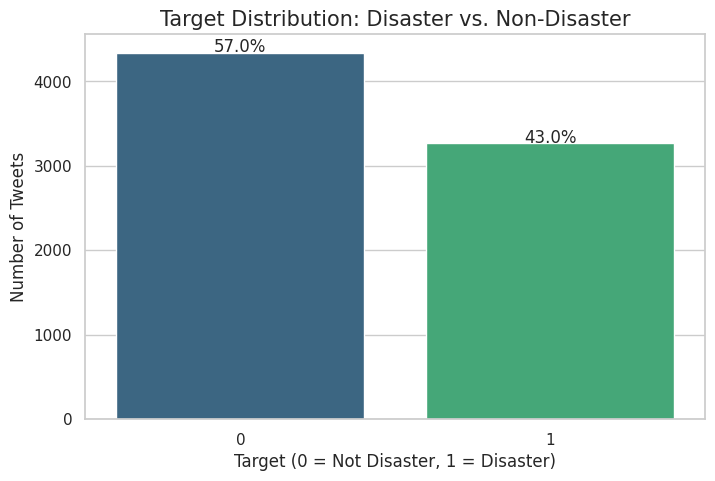

In [5]:
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='target', data=df, hue='target', palette='viridis', legend=False)

# Add labels and title
plt.title('Target Distribution: Disaster vs. Non-Disaster', fontsize=15)
plt.xlabel('Target (0 = Not Disaster, 1 = Disaster)', fontsize=12)
plt.ylabel('Number of Tweets', fontsize=12)

# Add percentage labels on top of the bars
total = len(df)
for p in ax.patches:
    height = p.get_height()
    percentage = f'{100 * height / total:.1f}%'
    ax.text(p.get_x() + p.get_width()/2., height + 3, percentage, ha="center")

plt.show()

Well, pretty good for training. Sure, it's not 50/50, but this ratio distrubution will work

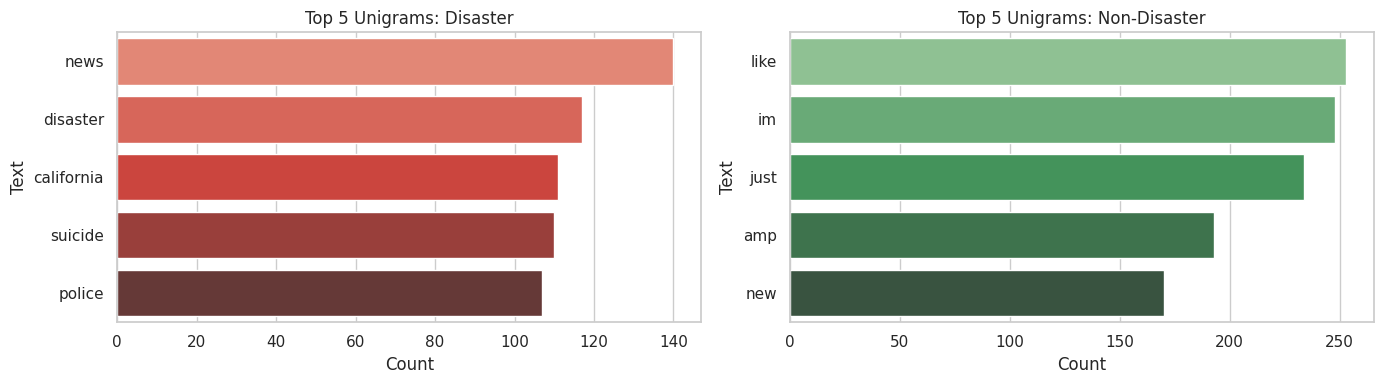

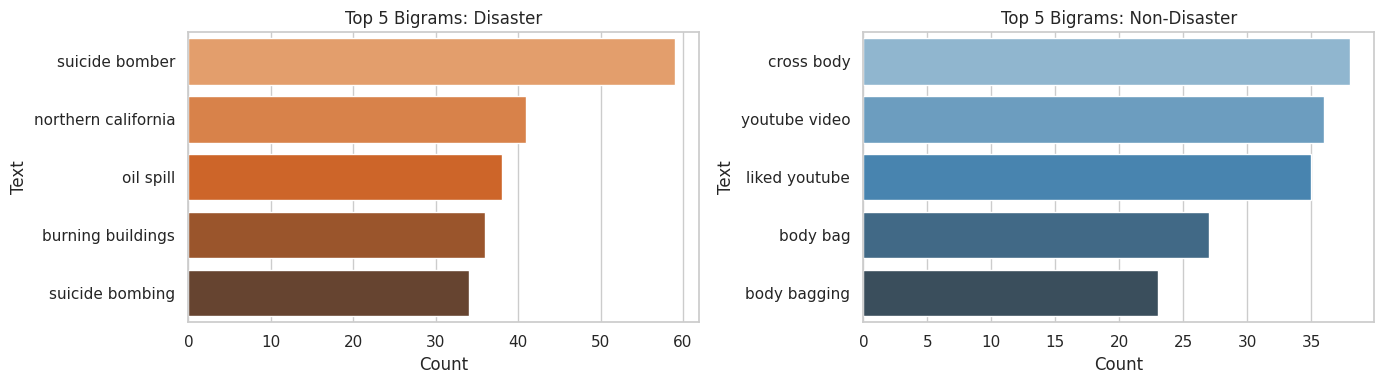

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import re

# Basic Cleaning
def clean_text(text):
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    return text

df['clean_text'] = df['text'].apply(clean_text)

# Function for Top N-Grams (set to top 5)
def get_top_ngram(corpus, n=1, top_k=5):
    vec = CountVectorizer(stop_words='english', ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return pd.DataFrame(words_freq[:top_k], columns=['Text', 'Count'])

# Generate Data
uni_d = get_top_ngram(df[df['target']==1]['clean_text'], n=1)
uni_nd = get_top_ngram(df[df['target']==0]['clean_text'], n=1)
bi_d = get_top_ngram(df[df['target']==1]['clean_text'], n=2)
bi_nd = get_top_ngram(df[df['target']==0]['clean_text'], n=2)

# Visualization: Top 5 Unigrams
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
sns.barplot(x='Count', y='Text', data=uni_d, ax=axes[0], palette='Reds_d', hue='Text', legend=False)
axes[0].set_title('Top 5 Unigrams: Disaster')

sns.barplot(x='Count', y='Text', data=uni_nd, ax=axes[1], palette='Greens_d', hue='Text', legend=False)
axes[1].set_title('Top 5 Unigrams: Non-Disaster')
plt.tight_layout()
plt.show()

# Visualization: Top 5 Bigrams
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
sns.barplot(x='Count', y='Text', data=bi_d, ax=axes[0], palette='Oranges_d', hue='Text', legend=False)
axes[0].set_title('Top 5 Bigrams: Disaster')

sns.barplot(x='Count', y='Text', data=bi_nd, ax=axes[1], palette='Blues_d', hue='Text', legend=False)
axes[1].set_title('Top 5 Bigrams: Non-Disaster')
plt.tight_layout()
plt.show()

   Target  Total Hashtags  Average Hashtags per Tweet
0       0            1688                    0.388761
1       1            1642                    0.501987


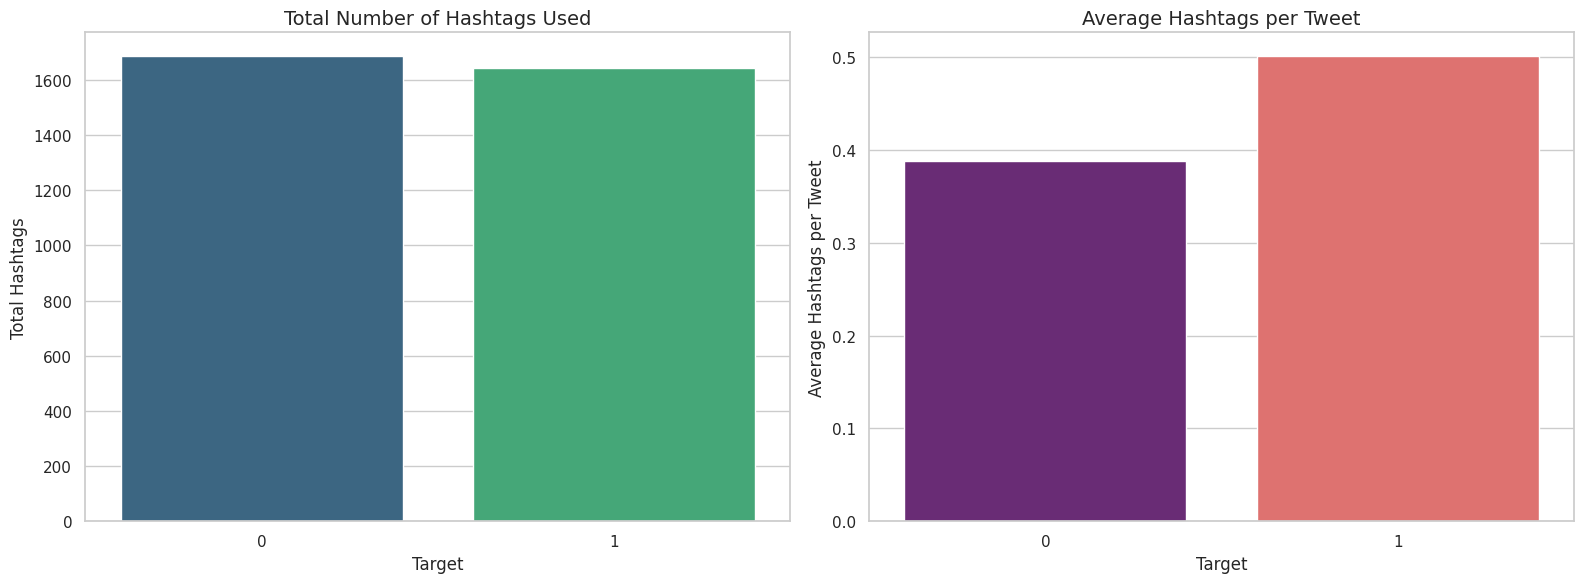

In [7]:
# 1. Extract and Count Hashtags
def count_hashtags(text):
    # This looks for the '#' symbol followed by alphanumeric characters
    hashtags = re.findall(r'#(\w+)', str(text))
    return len(hashtags)

df['hashtag_count'] = df['text'].apply(count_hashtags)

# 2. Calculate Statistics (Total and Average)
hashtag_stats = df.groupby('target')['hashtag_count'].agg(['sum', 'mean']).reset_index()
hashtag_stats.columns = ['Target', 'Total Hashtags', 'Average Hashtags per Tweet']
print(hashtag_stats)

# 3. Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot Total Count - Added hue and legend=False
sns.barplot(
    x='Target', 
    y='Total Hashtags', 
    data=hashtag_stats, 
    ax=axes[0], 
    palette='viridis', 
    hue='Target', 
    legend=False
)
axes[0].set_title('Total Number of Hashtags Used', fontsize=14)

# Plot Average Count - Added hue and legend=False
sns.barplot(
    x='Target', 
    y='Average Hashtags per Tweet', 
    data=hashtag_stats, 
    ax=axes[1], 
    palette='magma', 
    hue='Target', 
    legend=False
)
axes[1].set_title('Average Hashtags per Tweet', fontsize=14)

plt.tight_layout()
plt.show()

In [8]:
import re
from collections import Counter

# 1. Function to extract hashtag words
def extract_hashtags(text):
    return re.findall(r'#(\w+)', str(text).lower())

# 2. Collect all hashtags for each target
disaster_tags = []
df[df['target'] == 1]['text'].apply(lambda x: disaster_tags.extend(extract_hashtags(x)))

non_disaster_tags = []
df[df['target'] == 0]['text'].apply(lambda x: non_disaster_tags.extend(extract_hashtags(x)))

# 3. Print Top 10 for each
print("--- Top 10 Disaster Hashtags ---")
print(Counter(disaster_tags).most_common(10))

print("\n--- Top 10 Non-Disaster Hashtags ---")
print(Counter(non_disaster_tags).most_common(10))

--- Top 10 Disaster Hashtags ---
[('news', 56), ('hiroshima', 22), ('earthquake', 19), ('hot', 13), ('prebreak', 13), ('best', 13), ('japan', 11), ('india', 10), ('yyc', 10), ('breaking', 9)]

--- Top 10 Non-Disaster Hashtags ---
[('nowplaying', 21), ('news', 20), ('hot', 18), ('prebreak', 17), ('best', 17), ('gbbo', 14), ('jobs', 14), ('islam', 14), ('job', 12), ('hiring', 10)]


Missing values per column:
id                  0
keyword            61
location         2533
text                0
target              0
clean_text          0
hashtag_count       0
dtype: int64
--- Missing Values for Non-Disaster (Total: 4342) ---
keyword       19
location    1458
dtype: int64
Percentage Location Missing: 33.58%
----------------------------------------
--- Missing Values for Disaster (Total: 3271) ---
keyword       42
location    1075
dtype: int64
Percentage Location Missing: 32.86%
----------------------------------------


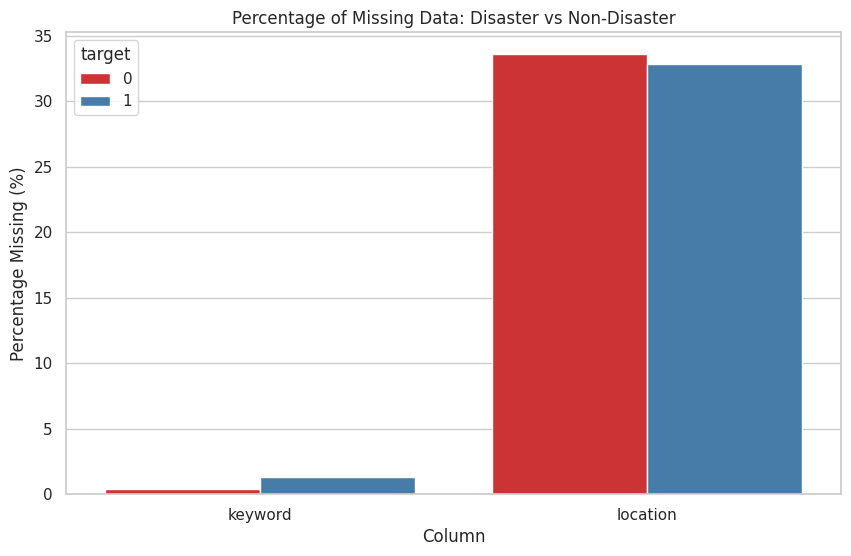

In [9]:
missing_data = df.isnull().sum()
print("Missing values per column:")
print(missing_data)

# 1. Create a function to summarize missing values
def check_missing_by_target(df):
    for target in [0, 1]:
        label = "Disaster" if target == 1 else "Non-Disaster"
        subset = df[df['target'] == target]
        print(f"--- Missing Values for {label} (Total: {len(subset)}) ---")
        print(subset[['keyword', 'location']].isnull().sum())
        print(f"Percentage Location Missing: {subset['location'].isnull().sum()/len(subset):.2%}")
        print("-" * 40)

check_missing_by_target(df)

# 2. Visualizing it
missing_df = df.groupby('target')[['keyword', 'location']].apply(lambda x: x.isnull().mean() * 100).reset_index()
missing_df = missing_df.melt(id_vars='target', var_name='Column', value_name='Percentage_Missing')

plt.figure(figsize=(10, 6))
sns.barplot(data=missing_df, x='Column', y='Percentage_Missing', hue='target', palette='Set1')
plt.title('Percentage of Missing Data: Disaster vs Non-Disaster')
plt.ylabel('Percentage Missing (%)')
plt.show()

--- Word Count Statistics ---
   Target  Avg Words  Max Words  Min Words
0       0  14.704744         31          1
1       1  15.167533         30          2


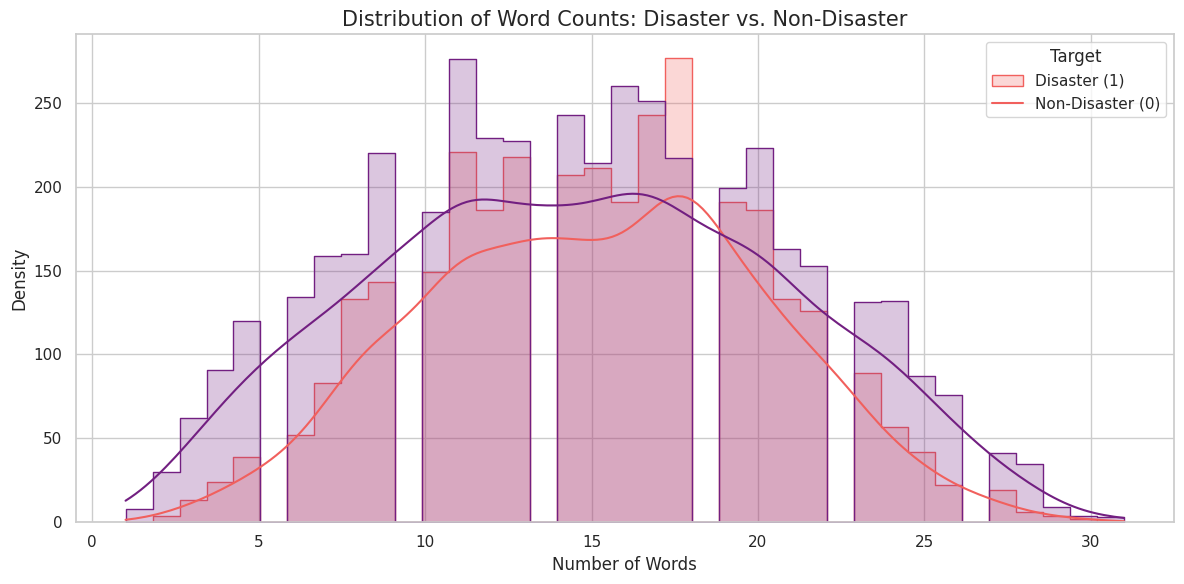

In [10]:
#  Create a word count column
# We split the text by spaces to count the words
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

#  Calculate average, max, and min word count
word_stats = df.groupby('target')['word_count'].agg(['mean', 'max', 'min']).reset_index()
word_stats.columns = ['Target', 'Avg Words', 'Max Words', 'Min Words']

print("--- Word Count Statistics ---")
print(word_stats)

#  Visualization: Normal Distribution Type Plot
plt.figure(figsize=(12, 6))

sns.histplot(data=df, x='word_count', hue='target', kde=True, element="step", palette='magma', common_norm=False)

plt.title('Distribution of Word Counts: Disaster vs. Non-Disaster', fontsize=15)
plt.xlabel('Number of Words', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(title='Target', labels=['Disaster (1)', 'Non-Disaster (0)'])

plt.tight_layout()
plt.show()

## TRAINING A BERT MODEL FOR THIS TASK

In [11]:
model_dir = "/kaggle/input/bert-base-uncased/pytorch/default/1/bert-base-uncased"
tokenizer = BertTokenizerFast.from_pretrained(model_dir)

**Data Splitting**

In [12]:
# 2. Split data with stratification
# 'df_final' is your dataframe, 'target' is your column name (0 or 1)
train_df, valid_df = train_test_split(
    df, 
    test_size=CONFIG['val_split'],
    random_state=CONFIG['random_seed'],
    stratify=df['target'] # This keeps the 0/1 ratio consistent
)

# 3. Print verification stats
print(f"Train samples: {len(train_df)}")
print(f"Valid samples: {len(valid_df)}")
print(f"Total samples: {len(train_df) + len(valid_df)}")

print(f"\n--- Train class distribution ---")
train_class_dist = train_df['target'].value_counts().sort_index()
for idx, count in train_class_dist.items():
    label = "Disaster" if idx == 1 else "Non-Disaster"
    print(f"  {label} ({idx}): {count} ({count/len(train_df)*100:.1f}%)")

print(f"\n--- Valid class distribution ---")
valid_class_dist = valid_df['target'].value_counts().sort_index()
for idx, count in valid_class_dist.items():
    label = "Disaster" if idx == 1 else "Non-Disaster"
    print(f"  {label} ({idx}): {count} ({count/len(valid_df)*100:.1f}%)")

Train samples: 6090
Valid samples: 1523
Total samples: 7613

--- Train class distribution ---
  Non-Disaster (0): 3473 (57.0%)
  Disaster (1): 2617 (43.0%)

--- Valid class distribution ---
  Non-Disaster (0): 869 (57.1%)
  Disaster (1): 654 (42.9%)


In [13]:
class PairwiseDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=128):
        # 1. We copy the dataframe so we don't mess up the original
        self.df = df.copy().reset_index(drop=True)
        
        # 2. DO THE LOGIC HERE (Once!)
        self.df['keyword'] = self.df['keyword'].fillna('none')
        self.df['location'] = self.df['location'].fillna('none')
        self.df['final_input'] = (
            self.df['keyword'] + " | " + 
            self.df['location'] + " | " + 
            self.df['text']
        )
        
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # 3. Just grab the ready-made string
        text = self.df.loc[idx, "final_input"]
        label = int(self.df.loc[idx, "target"])

        enc = self.tokenizer(
            text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            add_special_tokens=True,
            return_tensors="pt"
        )

        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long)
        }

In [14]:
# Create dataset instances
train_dataset = PairwiseDataset(train_df, tokenizer, max_len=CONFIG['max_tokens'])
val_dataset = PairwiseDataset(valid_df, tokenizer, max_len=CONFIG['max_tokens'])

print(f"Train dataset size: {len(train_dataset)}")
print(f"Valid dataset size: {len(val_dataset)}")

# Test a sample
sample = train_dataset[0]
print(f"\nSample from train dataset:")
print(f"  input_ids shape: {sample['input_ids'].shape}")
print(f"  attention_mask shape: {sample['attention_mask'].shape}")
print(f"  label: {sample['labels'].item()}")


Train dataset size: 6090
Valid dataset size: 1523

Sample from train dataset:
  input_ids shape: torch.Size([512])
  attention_mask shape: torch.Size([512])
  label: 1


In [15]:
# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=0
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=0
)

print(f"Train loader batches: {len(train_loader)}")
print(f"Valid loader batches: {len(val_loader)}")
print(f"Batch size: {CONFIG['batch_size']}")

# Show a sample batch
sample_batch = next(iter(train_loader))
print(f"\nSample batch shapes:")
print(f"  input_ids: {sample_batch['input_ids'].shape}")
print(f"  attention_mask: {sample_batch['attention_mask'].shape}")
print(f"  labels: {sample_batch['labels'].shape}")
print(f"  label values: {sample_batch['labels'].cpu().numpy()}")


Train loader batches: 191
Valid loader batches: 48
Batch size: 32

Sample batch shapes:
  input_ids: torch.Size([32, 512])
  attention_mask: torch.Size([32, 512])
  labels: torch.Size([32])
  label values: [1 1 1 0 1 0 1 0 0 1 0 1 0 1 1 0 0 1 1 1 0 0 1 1 0 0 0 1 0 1 0 1]


In [16]:
# Initialize model with dropout for regularization
model = BertForSequenceClassification.from_pretrained(
    model_dir,
    num_labels=2,
    hidden_dropout_prob=0.2,
    attention_probs_dropout_prob=0.2,
    ignore_mismatched_sizes=True
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model loaded successfully!")
print(f"Device: {device}")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Model loaded successfully!
Device: cuda
Total parameters: 109,483,778
Trainable parameters: 109,483,778


In [17]:
from sklearn.metrics import accuracy_score, f1_score

# 1. Improved Metrics Function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1}

In [18]:
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor="val_loss", patience=10, mode="min")
checkpoint = ModelCheckpoint(
    monitor="val_loss",
    mode="min",
    save_top_k=1,
    filename="best_exam_model"
)

In [19]:
# 2. Proper Training Arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,              
    per_device_train_batch_size=8,   # Balanced size
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    
    # Progress & Logging
    logging_strategy="steps",
    logging_steps=10,                # Set to 10 so the progress bar is stable
    eval_strategy="steps",           # Evaluate periodically
    eval_steps=50,                   
    save_strategy="steps",
    save_steps=50,
    
    # Optimization
    fp16=True,                       # Fast training
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none",                # Keeps it clean
    disable_tqdm=False               # Ensure progress bar is ON
)

In [20]:
#  Initialize Trainer with native EarlyStopping
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    # Use the Transformers EarlyStopping, not PyTorch Lightning's
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)] 
)

# 4. Start Training
print("Starting Training...")
trainer.train()

Starting Training...


Step,Training Loss,Validation Loss,Accuracy,F1
50,0.690700,0.673891,0.570584,0.000000
100,0.619100,0.593985,0.723572,0.559162
150,0.592800,0.513218,0.767564,0.746781
200,0.484500,0.553803,0.743270,0.738111
250,0.578600,0.510774,0.757058,0.745879
300,0.585800,0.595067,0.779383,0.761024
350,0.434900,0.493684,0.793171,0.705332
400,0.489200,0.514694,0.810900,0.783133
450,0.608700,0.551662,0.751149,0.755956
500,0.399800,0.635211,0.749836,0.754668


TrainOutput(global_step=750, training_loss=0.5505454711914063, metrics={'train_runtime': 702.5292, 'train_samples_per_second': 26.006, 'train_steps_per_second': 3.254, 'total_flos': 1578666332160000.0, 'train_loss': 0.5505454711914063, 'epoch': 0.984251968503937})

In [21]:
import matplotlib.pyplot as plt

# Access the log history
history = trainer.state.log_history

# Filter out train and validation logs
train_loss = [log['loss'] for log in history if 'loss' in log]
train_steps = [log['step'] for log in history if 'loss' in log]

val_loss = [log['eval_loss'] for log in history if 'eval_loss' in log]
val_steps = [log['step'] for log in history if 'eval_loss' in log]

val_f1 = [log['eval_f1'] for log in history if 'eval_f1' in log]

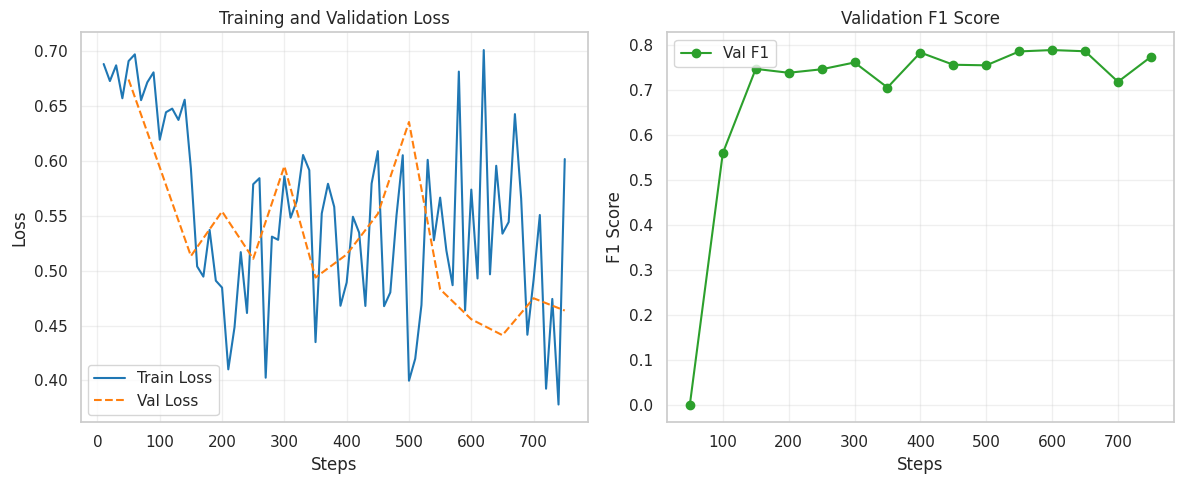

In [22]:
plt.figure(figsize=(12, 5))

# Plot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(train_steps, train_loss, label='Train Loss', color='#1f77b4')
if val_loss:
    plt.plot(val_steps, val_loss, label='Val Loss', color='#ff7f0e', linestyle='--')
plt.title('Training and Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: F1 Score
plt.subplot(1, 2, 2)
if val_f1:
    plt.plot(val_steps, val_f1, label='Val F1', color='#2ca02c', marker='o')
plt.title('Validation F1 Score')
plt.xlabel('Steps')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [23]:
test_df = pd.read_csv(TEST_FILE)
test_df['target'] = 0
test_dataset = PairwiseDataset(test_df, tokenizer, max_len=CONFIG['max_tokens'])

In [24]:
raw_predictions = trainer.predict(test_dataset)

# raw_predictions.predictions contains the 'logits' (raw scores before softmax)
# We take the argmax to get the class with the highest score (0 or 1)
predictions = np.argmax(raw_predictions.predictions, axis=-1)

print(f"Predictions completed for {len(predictions)} samples.")

Predictions completed for 3263 samples.


In [25]:
import pandas as pd

# Create the final dataframe
submission = pd.DataFrame({
    "id": test_df["id"],
    "target": predictions
})

# submission.head(10)

In [26]:
# Save to CSV
submission.to_csv("submission.csv", index=False)

print("Submission file saved as 'submission.csv'!")
print(submission.head())

Submission file saved as 'submission.csv'!
   id  target
0   0       1
1   2       1
2   3       1
3   9       1
4  11       1
